### 미니 배치 경사 하강법 구현

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [35]:
class SingleLayer:    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b        # 선형 출력을 계산합니다. (364,30)(30,1)=>(364,1)+(364,1)
        return z

    def backprop(self, x, err):              #  x.shape => (364,30) , err => (364,1)
        m = len(x)                           # (30,364)(364,1)=>(30,1)
        w_grad = np.dot(x.T, err) / m         # 가중치에 대한 그래디언트를 계산합니다.
        b_grad = np.sum(err) / m              # 절편에 대한 그래디언트를 계산합니다.
        return w_grad, b_grad                 # b 스칼라 => b_grad 스칼라

    def activation(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):  # x.shape => (364,30)
#         print(x.shape)
#         print(y.shape)
        y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.  y.shape (364,) => y.reshape(-1,1)
#         print(y.shape)
        
        y_val = y_val.reshape(-1, 1)
        m = len(x)                            # 샘플 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다. w.shape => (30,1)
#         print(self.w.shape)
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
#             print(x.shape)
            z = self.forpass(x)               # 정방향 계산을 수행합니다.  x.shape => (364,30)(30,1)
#             print(z.shape)
            a = self.activation(z)            # 활성화 함수를 적용합니다.  a.shape => (364,1)
#             print(a.shape)
            err = a - y                   # 오차를 계산합니다.   y.shape => (364,1)
#             print(err.shape)
#             print(err)
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)  #  x.shape => (364,30) , err => (364,1)
#             print(w_grad.shape)
#             print(b_grad.shape)
            
            # 그래디언트에서 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편을 업데이트합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = self.forpass(x)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [36]:
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.activation(z1)            # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)               # 은닉층의 크기
        self.w2 = np.ones((self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)          # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                    # 샘플 개수를 저장합니다.
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            a = self.training(x, y, m)
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.activation(z)    # 활성화 함수를 적용합니다.
        err = (a - y)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [37]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0

### 파이썬의 제너레이터 함수

In [40]:
def foo():
    ret = 10   # 스택
    print('foo()')
    return ret
    print('after')
    
c = foo()
print(c)
print(ret)

foo()
10


NameError: name 'ret' is not defined

In [42]:
def foo():
    print('foo()')
    yield 10

c = foo()
print(c)
print(next(c))

<generator object foo at 0x000001DED5F07190>
foo()
10


In [45]:
def foo():
    print('foo()')
    yield 10
    print('after')
    yield 20

c = foo()
print(c)
n = next(c)
print(n)
n = next(c)
print(n)

<generator object foo at 0x000001DEC2CF0E40>
foo()
10
after
20


In [49]:
def foo():
    print('foo()')
    yield 10
    yield 20

c = foo()
print(c)
n = next(c)
print(n)
n = next(c)
print(n)
n = next(c)
print(n)

<generator object foo at 0x000001DED5F07660>
foo()
10
20


StopIteration: 

In [50]:
def foo():
    print('foo()')
    yield 10
    yield 20

for n in foo():
    print(n)

foo()
10
20


In [52]:
def foo():
    print('foo()')
    a = np.arange(100)
    print(a.shape)
    return a[0:10]

c = foo()
print(c.shape)
print(c)
c = foo()
print(c.shape)
print(c)

foo()
(100,)
(10,)
[0 1 2 3 4 5 6 7 8 9]
foo()
(100,)
(10,)
[0 1 2 3 4 5 6 7 8 9]


In [58]:
a = np.arange(7)
b = a[0:10]
print(b)

[0 1 2 3 4 5 6]


In [61]:
def foo():
    print('foo()')
    a = np.arange(100,205)
#     print(a)
    batch = 10
    length = len(a)
    bins = length // batch
    if length % batch != 0 :
        bins += 1
    for i in range(bins):
        start = batch*i
        end = batch*(i+1)
        yield a[start:end]

# c = foo()
# print(c)
# n = next(c)
# print(n)
# n = next(c)
# print(n)
for n in foo():
    print(n)

foo()
[100 101 102 103 104 105 106 107 108 109]
[110 111 112 113 114 115 116 117 118 119]
[120 121 122 123 124 125 126 127 128 129]
[130 131 132 133 134 135 136 137 138 139]
[140 141 142 143 144 145 146 147 148 149]
[150 151 152 153 154 155 156 157 158 159]
[160 161 162 163 164 165 166 167 168 169]
[170 171 172 173 174 175 176 177 178 179]
[180 181 182 183 184 185 186 187 188 189]
[190 191 192 193 194 195 196 197 198 199]
[200 201 202 203 204]


### 미니 배치 학습의 구현

In [62]:
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size     # 배치 크기
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)     # 타깃을 열 벡터로 바꿉니다.
        self.init_weights(x.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        np.random.seed(42)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1) # 타깃을 열 벡터로 바꿉니다.
                m = len(x_batch)                 # 샘플 개수를 저장합니다.
                a = self.training(x_batch, y_batch, m)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

In [63]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, 
                  x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

0.978021978021978

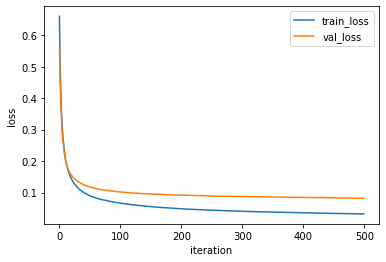

In [64]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

####  케라스를 이용한 미니배치 구현

Epoch 1/100
12/12 [==============================] - 0s 8ms/step - loss: 0.7442 - accuracy: 0.6374 - val_loss: 0.7442 - val_accuracy: 0.5824
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 0.7151 - accuracy: 0.6374 - val_loss: 0.7162 - val_accuracy: 0.5824
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.6374 - val_loss: 0.6896 - val_accuracy: 0.5824
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 0.6649 - accuracy: 0.6374 - val_loss: 0.6664 - val_accuracy: 0.5824
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 0.6426 - accuracy: 0.6374 - val_loss: 0.6440 - val_accuracy: 0.5824
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.6218 - accuracy: 0.6374 - val_loss: 0.6234 - val_accuracy: 0.5824
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 0.6027 - accuracy: 0.6429 - val_loss: 0.6041 - val_accuracy: 0.6044
Epoch 8/100
1

Epoch 59/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2864 - accuracy: 0.9478 - val_loss: 0.2859 - val_accuracy: 0.9341
Epoch 60/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2845 - accuracy: 0.9451 - val_loss: 0.2839 - val_accuracy: 0.9341
Epoch 61/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2826 - accuracy: 0.9478 - val_loss: 0.2819 - val_accuracy: 0.9341
Epoch 62/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2807 - accuracy: 0.9478 - val_loss: 0.2799 - val_accuracy: 0.9341
Epoch 63/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.9478 - val_loss: 0.2780 - val_accuracy: 0.9341
Epoch 64/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2772 - accuracy: 0.9478 - val_loss: 0.2761 - val_accuracy: 0.9341
Epoch 65/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2755 - accuracy: 0.9478 - val_loss: 0.2743 - val_accuracy: 0.9341
Epoch 

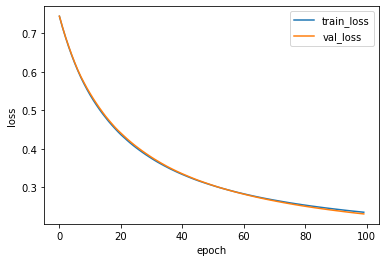

In [69]:
from tensorflow.keras.models import Sequential # 케라스의 Sequential()을 임포트
from tensorflow.keras.layers import Dense      # 케라스의 Dense()를 임포트
from tensorflow.keras import optimizers        # 케라스의 옵티마이저를 임포트
from tensorflow.keras import regularizers

import numpy as np # Numpy를 임포트
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental import preprocessing

cancer = load_breast_cancer()

x = cancer.data
y = cancer.target

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, 
test_size=0.2, random_state=42)

layer = preprocessing.Normalization()
layer.adapt(x_train)

model=Sequential()
model.add(layer)
model.add(Dense(20, input_dim=30, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
SGD=optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=SGD ,loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train,y_train, batch_size=32, epochs=100, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()